In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import scipy.signal as signal
plt.rcParams.update({'font.size': 15})

from adaptive_filters.normLMS import normLMS

# Adaptive line enhance for noisy ECG signals using normalized LMS

In this demo we will use the LMS algorithm for suppressing interference from a signal of interest.
The signal is a measurement of electrical activity of the human heart. This is also known as
an electrocardiogram (ECG). In our case the measurement is contaminated by sinusoidal interference
from the power network. In this version we will implement an adaptive line enhancer to remove the noise pollution.

## Load noisy data file

In [3]:
def load_data(path):
    with open(path) as data:
        out = data.readlines()

    return [float(x) for x in out]

In [4]:
path = './ecg.txt'
sample_rate = 500  # Hz
ecg_data = np.array(load_data(path))
ecg_data /= np.max(ecg_data)

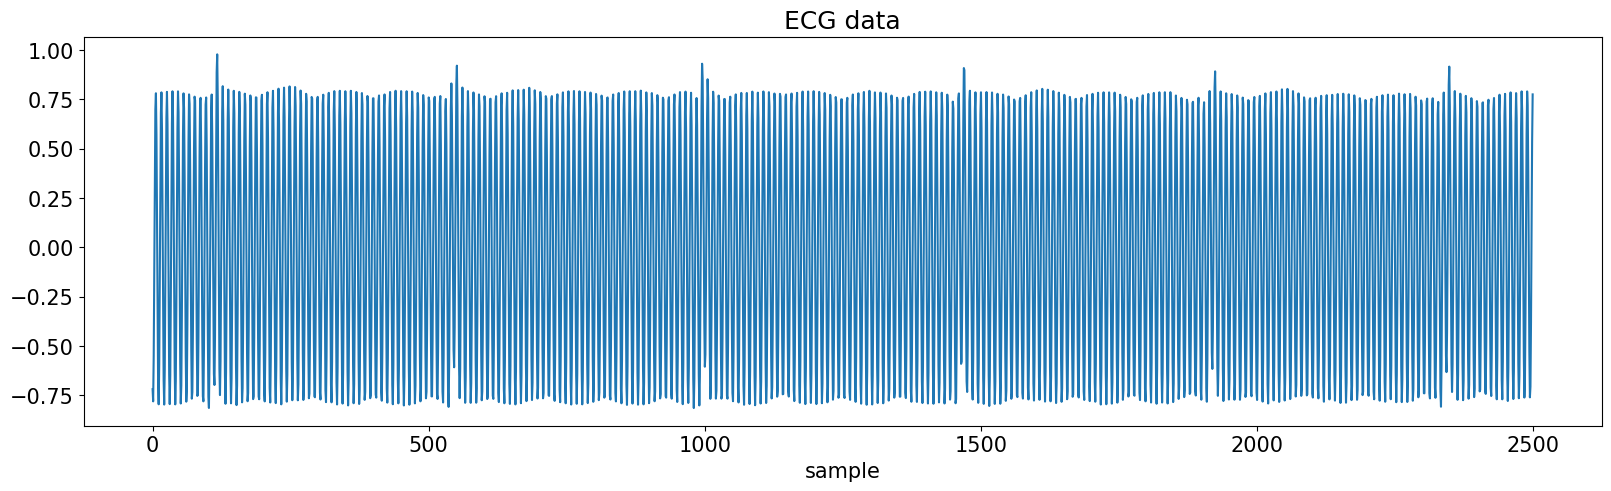

In [5]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:2500])
plt.show()

## ALE setup
It is basically an M-step-ahead predictor. The assumption is that the noise samples, which are more than M samples apart, are uncorrelated with one another. As a result, the predictor can only make a prediction of the sinusoidal components of the input signal and when adapted to minimize the output MSE, the line enhancer will be a filter tuned to the sinusoidal components. The maximum possible rejection of the noise will also be achieved as any portion of the noise, which passes through the prediction filter, will enhance the output MSE whose minimization is the criterion in adapting the filter tap weights.

![ALE_problem](img/ALE_problem.png)


## delay
To remove this noise component we set up an adaptive line enhancer. For this we firstly need a signal delayer

In [10]:
def signal_delay(signal, delay_taps):
    delayed_signal = np.zeros(signal.shape)
    delayed_signal[delay_taps:] = signal[:-delay_taps]
    return delayed_signal

# LMS
Finally, we initiate the LMS adaptive filter algorithm

In [41]:
delay = 1  # start with assuming white noise
filter_taps = 5  # small filter to start with
weights = np.zeros(filter_taps)

ale = normLMS(signal_delay(ecg_data, delay), ecg_data,weights, mu_heuristic=0.005, psi=0.001)
weights = ale.adapt_weights()

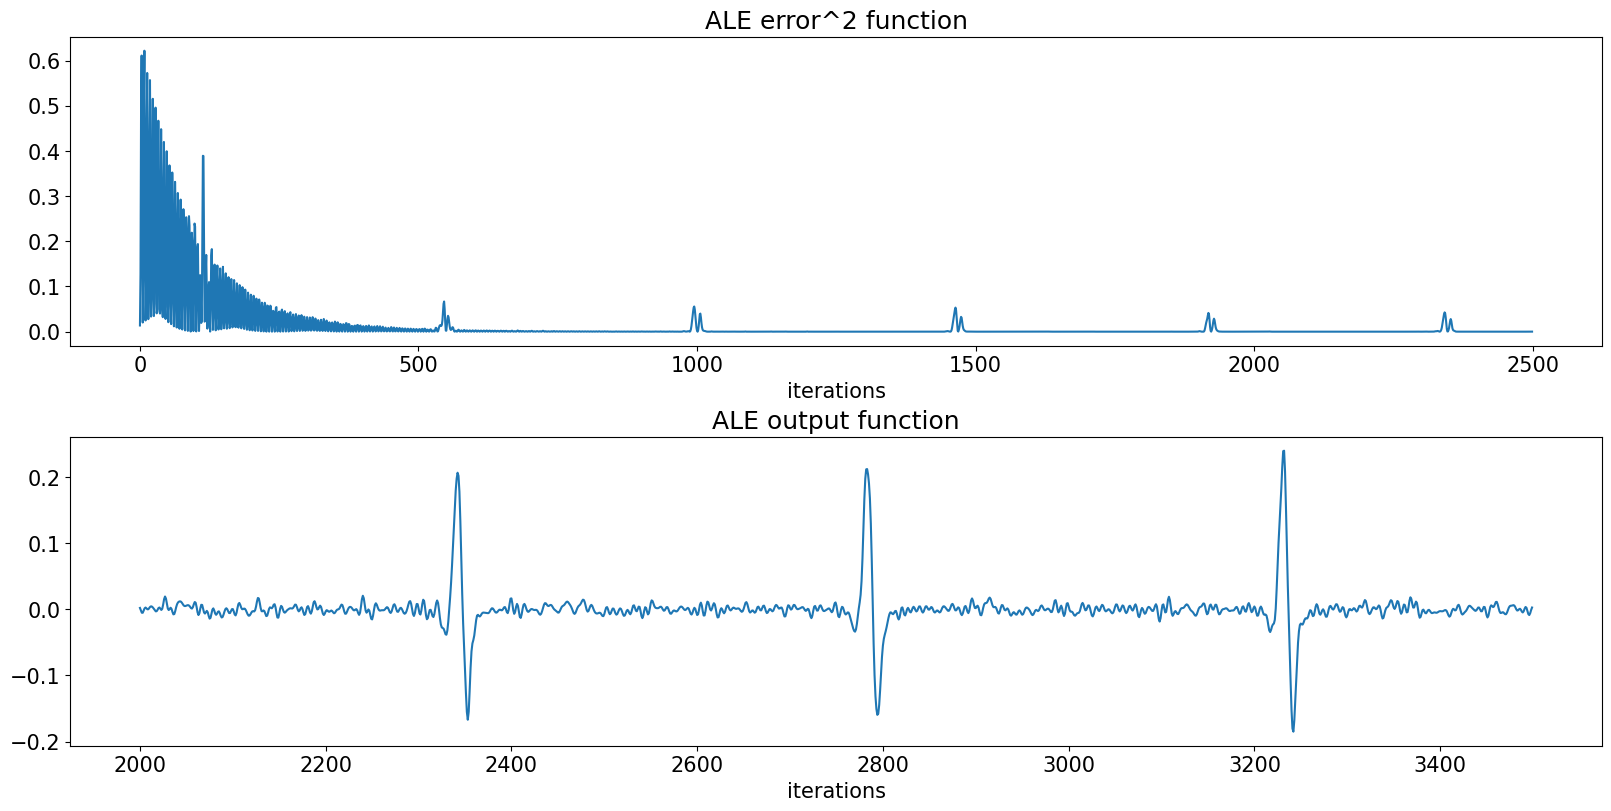

In [50]:
fig, ax = plt.subplots(2, constrained_layout=True)
fig.set_figwidth(16)
fig.set_figheight(8)
ax[0].set_xlabel('iterations')
ax[1].set_xlabel('iterations')

ax[0].set_title('ALE error^2 function')
ax[0].plot(ale.error[:2500]**2)

ax[1].set_title('ALE output function')
ax[1].plot(np.arange(2000,3500),ale.error[2000:3500])

plt.show()

### We can now try to improve this, by setting different delays

In [55]:
delays = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
filter_taps = 3  # small filter to start with
error_runs = np.empty((len(ecg_data) - filter_taps, len(delays)))

for i,delay in enumerate(delays):
    weights = np.zeros(filter_taps)
    ale = normLMS(signal_delay(ecg_data, delay), ecg_data,weights, mu_heuristic=0.05, psi=0.001)
    weights = ale.adapt_weights()
    error_runs[:, i] = ale.error

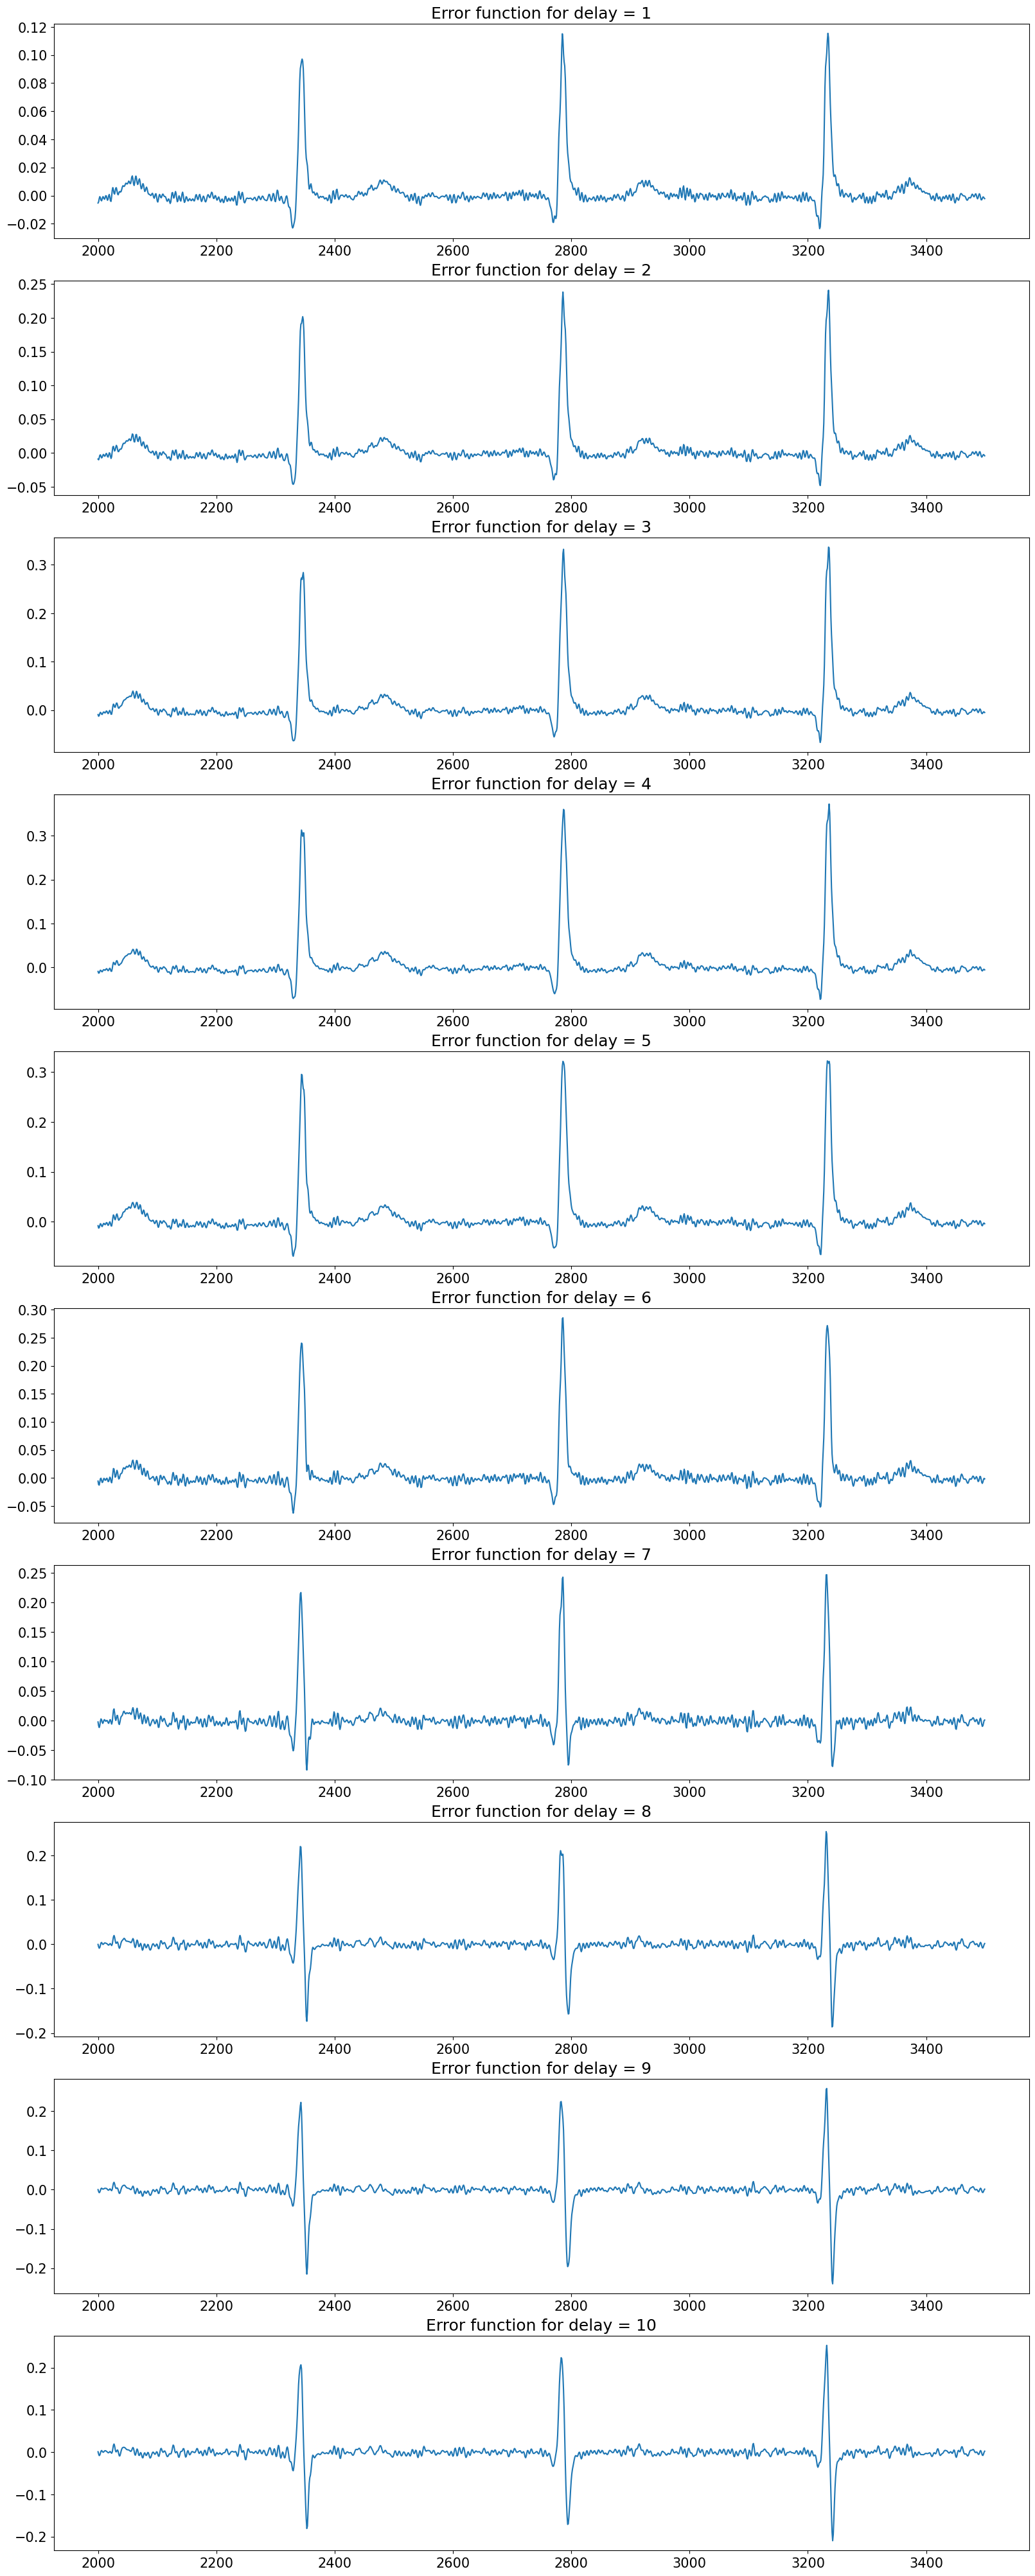

In [56]:
fig, axes = plt.subplots(len(delays), constrained_layout=True)
fig.set_figwidth(16)
fig.set_figheight(4*len(delays))

for i,ax in enumerate(axes):
    ax.set_title(f"Error function for delay = {delays[i]}")
    ax.plot(np.arange(2000,3500),error_runs[2000:3500, i])

plt.show()